<a href="https://colab.research.google.com/github/Capstone-Team-CH2-PS379/Machine-Learning/blob/main/model-experiments/Speech_Recognition_Model_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data

In [ ]:
!pip install kaggle

In [ ]:
# Library
import os
import pathlib
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [ ]:
# Set Kaggle API Key as environment variable
os.environ['KAGGLE_USERNAME'] =
os.environ['KAGGLE_KEY'] =

In [ ]:
# Download dataset
!kaggle datasets download -d mozillaorg/common-voice

100% 12.0G/12.0G [01:57<00:00, 106MB/s] 
100% 12.0G/12.0G [01:57<00:00, 110MB/s]


In [ ]:
# Extract zipfile to folder
import zipfile

with zipfile.ZipFile('common-voice.zip', 'r') as zip_ref:
    zip_ref.extractall('common-voice')

# Data Exploration

In [ ]:
print(os.listdir('/content/common-voice'))

['cv-other-test.csv', 'cv-invalid', 'cv-valid-train.csv', 'cv-invalid.csv', 'cv-valid-dev', 'cv-valid-test.csv', 'cv-other-dev', 'cv-other-test', 'cv-valid-test', 'cv-valid-train', 'cv-other-dev.csv', 'cv-valid-dev.csv', 'cv-other-train.csv', 'README.txt', 'cv-other-train', 'LICENSE.txt']


In [ ]:
# Read the CSV file
file_path_train = '/content/common-voice/cv-valid-train.csv'
data_train = pd.read_csv(file_path_train)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195776 entries, 0 to 195775
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   filename    195776 non-null  object 
 1   text        195776 non-null  object 
 2   up_votes    195776 non-null  int64  
 3   down_votes  195776 non-null  int64  
 4   age         73768 non-null   object 
 5   gender      74059 non-null   object 
 6   accent      64711 non-null   object 
 7   duration    0 non-null       float64
dtypes: float64(1), int64(2), object(5)
memory usage: 11.9+ MB


In [ ]:
# Set the option to display maximum column width
pd.set_option('display.max_colwidth', None)
data_train.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the old king had said,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dreams said the old woman,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those omens that brought you to me,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me be the first to welcome you to earth,3,2,NaN,NaN,NaN,NaN


In [ ]:
file_path_val = '/content/common-voice/cv-valid-dev.csv'
data_val = pd.read_csv(file_path_val)
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    4076 non-null   object 
 1   text        4076 non-null   object 
 2   up_votes    4076 non-null   int64  
 3   down_votes  4076 non-null   int64  
 4   age         1528 non-null   object 
 5   gender      1540 non-null   object 
 6   accent      1350 non-null   object 
 7   duration    0 non-null      float64
dtypes: float64(1), int64(2), object(5)
memory usage: 254.9+ KB


In [ ]:
data_val.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-dev/sample-000000.mp3,be careful with your prognostications said the stranger,1,0,NaN,NaN,NaN,NaN
1,cv-valid-dev/sample-000001.mp3,then why should they be surprised when they see one,2,0,NaN,NaN,NaN,NaN
2,cv-valid-dev/sample-000002.mp3,a young arab also loaded down with baggage entered and greeted the englishman,2,0,NaN,NaN,NaN,NaN
3,cv-valid-dev/sample-000003.mp3,i thought that everything i owned would be destroyed,3,0,NaN,NaN,NaN,NaN
4,cv-valid-dev/sample-000004.mp3,he moved about invisible but everyone could hear him,1,0,fourties,female,england,NaN


# Percobaan 13/12

## Audio to Spectrogram

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mengonversi file audio ke spektrogram
def audio_to_spectrogram(audio_path, max_length):
    # Muat file audio
    y, sr = librosa.load(audio_path, sr=None)

    # Ekstrak spektrogram menggunakan transformasi Log-Mel
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Pad atau potong spektrogram menjadi panjang maksimum yang diinginkan
    if spectrogram.shape[1] > max_length:
        spectrogram = spectrogram[:, :max_length]
    else:
        spectrogram = np.pad(spectrogram, ((0, 0), (0, max_length - spectrogram.shape[1])), mode='constant')

    return spectrogram

In [ ]:
# Contoh penggunaan
audio_path = '/content/common-voice/cv-valid-train/cv-valid-train/sample-000000.mp3'
max_audio_length = 400  # Sesuaikan dengan nilai yang diinginkan
spectrogram = audio_to_spectrogram(audio_path, max_audio_length)

# Tampilkan spektrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [ ]:
print(spectrogram)
print(spectrogram.shape)

## Tokenization

In [ ]:
sample_size_train = 1000
sample_size_val = 100

data_train_subset = data_train[:sample_size_train]
data_val_subset = data_val[:sample_size_val]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisasi teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train_subset['text'])  # Gunakan subset data_train yang sesuai
vocab_size = len(tokenizer.word_index) + 1

# Persiapkan data teks
sequences_train = tokenizer.texts_to_sequences(data_train_subset['text'])
sequences_val = tokenizer.texts_to_sequences(data_val_subset['text'])

# Find the maximum text length in the training subset
max_text_length_train = max(len(seq) for seq in sequences_train)

# Find the maximum text length in the validation subset
max_text_length_val = max(len(seq) for seq in sequences_val)

# Choose the maximum between training and validation max lengths
max_text_length = max(max_text_length_train, max_text_length_val)

padded_sequences_train = pad_sequences(sequences_train, maxlen=max_text_length, padding='post')
padded_sequences_val = pad_sequences(sequences_val, maxlen=max_text_length, padding='post')

In [ ]:
print(padded_sequences_train[0])
print(padded_sequences_val[0])

print(padded_sequences_train.shape)
print(padded_sequences_val.shape)

## Persiapan Data Audio

In [ ]:
audio_path_train = '/content/common-voice/cv-valid-train/'
audio_path_val = '/content/common-voice/cv-valid-dev/'

sample_size_train = 1000
sample_size_val = 100

data_train_subset = data_train[:sample_size_train]
data_val_subset = data_val[:sample_size_val]

In [ ]:
audio_data_train = [audio_to_spectrogram(audio_path_train + file, max_audio_length) for file in data_train_subset['filename']]
audio_data_val = [audio_to_spectrogram(audio_path_val + file, max_audio_length) for file in data_val_subset['filename']]

# Pastikan jumlah sampel audio dan teks sesuai
assert len(audio_data_train) == len(data_train_subset)
assert len(audio_data_val) == len(data_val_subset)

In [ ]:
import numpy as np

# Konversi list ke array NumPy
audio_data_train = np.array(audio_data_train)
audio_data_val = np.array(audio_data_val)

In [ ]:
print(audio_data_train[0])
print(audio_data_val[0])

print(audio_data_train.shape)
print(audio_data_val.shape)

In [ ]:
from sklearn.preprocessing import normalize

# Normalisasi pada setiap dimensi secara terpisah
normalized_audio_train = normalize(audio_data_train.reshape((audio_data_train.shape[0], -1)), axis=1).reshape(audio_data_train.shape)
normalized_audio_val = normalize(audio_data_val.reshape((audio_data_val.shape[0], -1)), axis=1).reshape(audio_data_val.shape)

In [ ]:
print(normalized_audio_train[0])
print(normalized_audio_val[0])

print(normalized_audio_train.shape)
print(normalized_audio_val.shape)

# Model Building

# Model Inference

# Percobaan 12/12

In [ ]:
# Hyperparameters
max_audio_length = 500  # Sesuaikan panjang maksimum audio
embedding_dim = 256
latent_dim = 512

## Audio to Spectrogram

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mengonversi file audio ke spektrogram
def audio_to_spectrogram(audio_path, max_length):
    # Muat file audio
    y, sr = librosa.load(audio_path, sr=None)

    # Ekstrak spektrogram menggunakan transformasi Log-Mel
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Pad atau potong spektrogram menjadi panjang maksimum yang diinginkan
    if spectrogram.shape[1] > max_length:
        spectrogram = spectrogram[:, :max_length]
    else:
        spectrogram = np.pad(spectrogram, ((0, 0), (0, max_length - spectrogram.shape[1])), mode='constant')

    return spectrogram

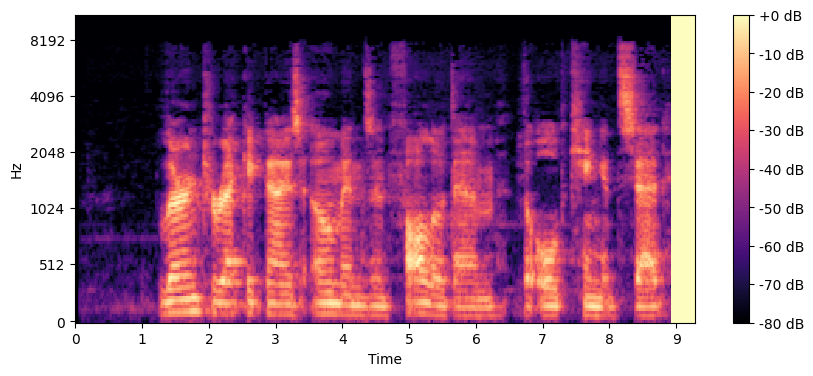

In [ ]:
# Contoh penggunaan
audio_path = '/content/common-voice/cv-valid-train/cv-valid-train/sample-000000.mp3'
max_audio_length = 400  # Sesuaikan dengan nilai yang diinginkan
spectrogram = audio_to_spectrogram(audio_path, max_audio_length)

# Tampilkan spektrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [ ]:
print(spectrogram)
print(spectrogram.shape)

[[-80.         -80.         -80.         -72.758255   -63.736515
  -62.108433   -65.2261     -66.905106   -60.718094   -62.26616
  -67.439514   -70.04338    -66.7715     -63.6188     -64.351295
  -64.58826    -62.884846   -61.719753   -62.1837     -64.42302
  -73.045074   -73.58296    -71.67781    -67.4426     -68.12962
  -62.78899    -62.713856   -63.36854    -60.683643   -64.53503
  -64.25636    -66.44719    -68.175415   -68.14173    -68.40553
  -64.80681    -61.03406    -64.76558    -65.26784    -62.924423
  -63.677357   -59.634396   -62.52646    -70.868805   -75.67493
  -73.40871    -76.7879     -71.97449    -61.71146    -57.717773
  -60.864716   -66.02159    -67.65963    -65.117065   -57.733543
  -48.55953    -42.719887   -43.49436    -43.181328   -41.18373
  -40.9214     -41.5968     -43.247623   -51.638252   -50.077377
  -46.4357     -46.619682   -50.188774   -44.580784   -48.62797
  -46.486004   -44.662636   -44.621105   -41.95906    -37.55648
  -37.70069    -40.587143   -44.80

## Tokenization

In [ ]:
sample_size_train = 1000
sample_size_val = 100

data_train_subset = data_train[:sample_size_train]
data_val_subset = data_val[:sample_size_val]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisasi teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train_subset['text'])  # Gunakan subset data_train yang sesuai
vocab_size = len(tokenizer.word_index) + 1

# Persiapkan data teks
sequences_train = tokenizer.texts_to_sequences(data_train_subset['text'])
sequences_val = tokenizer.texts_to_sequences(data_val_subset['text'])

# Find the maximum text length in the training subset
max_text_length_train = max(len(seq) for seq in sequences_train)

# Find the maximum text length in the validation subset
max_text_length_val = max(len(seq) for seq in sequences_val)

# Choose the maximum between training and validation max lengths
max_text_length = max(max_text_length_train, max_text_length_val)

padded_sequences_train = pad_sequences(sequences_train, maxlen=max_text_length, padding='post')
padded_sequences_val = pad_sequences(sequences_val, maxlen=max_text_length, padding='post')

In [ ]:
print(padded_sequences_train[0])
print(padded_sequences_val[0])

print(padded_sequences_train.shape)
print(padded_sequences_val.shape)

[315   2 909 176   4 589  65   1  78 134  14  15   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
[  27 1272   19   44 1273   15    1  456    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
(1000, 27)
(100, 27)


## Persiapan Data Audio

In [ ]:
audio_path_train = '/content/common-voice/cv-valid-train/'
audio_path_val = '/content/common-voice/cv-valid-dev/'

sample_size_train = 1000
sample_size_val = 100

data_train_subset = data_train[:sample_size_train]
data_val_subset = data_val[:sample_size_val]

In [ ]:
audio_data_train = [audio_to_spectrogram(audio_path_train + file, max_audio_length) for file in data_train_subset['filename']]
audio_data_val = [audio_to_spectrogram(audio_path_val + file, max_audio_length) for file in data_val_subset['filename']]

# Pastikan jumlah sampel audio dan teks sesuai
assert len(audio_data_train) == len(data_train_subset)
assert len(audio_data_val) == len(data_val_subset)

In [ ]:
import numpy as np

# Konversi list ke array NumPy
audio_data_train = np.array(audio_data_train)
audio_data_val = np.array(audio_data_val)

In [ ]:
print(audio_data_train[0])
print(audio_data_val[0])

print(audio_data_train.shape)
print(audio_data_val.shape)

Output streaming akan dipotong hingga 5000 baris terakhir.
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01 -8.00000000e+01 -8.00000000e+01 -8.00000000e+01
  -8.00000000e+01

In [ ]:
from sklearn.preprocessing import normalize

# Normalisasi pada setiap dimensi secara terpisah
normalized_audio_train = normalize(audio_data_train.reshape((audio_data_train.shape[0], -1)), axis=1).reshape(audio_data_train.shape)
normalized_audio_val = normalize(audio_data_val.reshape((audio_data_val.shape[0], -1)), axis=1).reshape(audio_data_val.shape)

In [ ]:
print(normalized_audio_train[0])
print(normalized_audio_val[0])

print(normalized_audio_train.shape)
print(normalized_audio_val.shape)

Output streaming akan dipotong hingga 5000 baris terakhir.
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.487868

## Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Concatenate
from tensorflow.keras.models import Model

# Hyperparameters
embedding_dim = 256
latent_dim = 512

In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_audio_length, 128))  # Sesuaikan dengan dimensi spektrogram
encoder_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
_, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h[:, :latent_dim], state_c[:, :latent_dim]]

# Decoder
decoder_inputs = Input(shape=(max_text_length - 1,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 400, 128)]           0         []                            
                                                                                                  
 bidirectional_10 (Bidirect  [(None, 1024),               2625536   ['input_31[0][0]']            
 ional)                       (None, 512),                                                        
                              (None, 512),                                                        
                              (None, 512),                                                        
                              (None, 512)]                                                        
                                                                                           

In [ ]:
normalized_audio_train_reshaped = normalized_audio_train.transpose(0, 2, 1)
normalized_audio_val_reshaped = normalized_audio_val.transpose(0, 2, 1)

In [ ]:
print(normalized_audio_train_reshaped[0])
print(normalized_audio_val_reshaped[0])

print(normalized_audio_train_reshaped.shape)
print(normalized_audio_val_reshaped.shape)

Output streaming akan dipotong hingga 5000 baris terakhir.
  -5.4658237e-03 -5.3659878e-03 -5.1690219e-03 -5.3732027e-03
  -5.0312066e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03
  -5.4878681e-03 -5.4878681e-03 -5.4878681e-03 -5.4878681e-03]
 [-3.5418058e-03 -3.4045600e-03 -2.1921166e-03 -1.9659344e-03
  -2.3259174e-03 -2.0030120e-03 -2.2219941e-03 -1.9175455e-03
  -1.8161716e-03 -2.0190994e-03 -1.9599104e-03 -1.9175961e-03
  -1.9117872e-03 -1.9159598e-03 -2.2240076e-03 -2.1437823e-03
  -1.9053709e-03 -2.0455499e-03 -2.1997995e-03 -2.1797388e-03
  -2.0953501e-03 -2.1009399e-03 -2.2845357e-03 -2.3385154e-03
  -2.1776520e-03 -2.1490164e-03 -2.2604130e-03 -2.3953391e-03
  -2.4709047e-03 -2.4494182e-03 -2.4787022e-03 -2.7614259e-03
  -2.9035469e-03 -3.0514421e-03 -3.3086466e-03 -3.2154331e-03
  -2.84988

In [ ]:
target_data_train = padded_sequences_train[:, :max_text_length - 1]  # Sesuaikan panjang target
target_data_val = padded_sequences_val[:, :max_text_length - 1]  # Sesuaikan panjang target untuk data validasi

print(target_data_train.shape)
print(target_data_val.shape)

(1000, 26)
(100, 26)


In [ ]:
model.fit(
    [normalized_audio_train_reshaped, padded_sequences_train[:, :-1]],
    np.expand_dims(target_data_train, -1),
    epochs=20,
    batch_size=16,
    validation_data=([normalized_audio_val_reshaped, padded_sequences_val[:, :-1]], np.expand_dims(target_data_val, -1))
)

Epoch 1/20
63/63 [==============================] - 12s 184ms/step - loss: 0.0849 - accuracy: 0.9958 - val_loss: 0.2709 - val_accuracy: 0.9685
Epoch 2/20
63/63 [==============================] - 7s 104ms/step - loss: 0.0571 - accuracy: 0.9972 - val_loss: 0.2533 - val_accuracy: 0.9685
Epoch 3/20
63/63 [==============================] - 7s 105ms/step - loss: 0.0393 - accuracy: 0.9985 - val_loss: 0.2400 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 6s 99ms/step - loss: 0.0283 - accuracy: 0.9993 - val_loss: 0.2315 - val_accuracy: 0.9696
Epoch 5/20
63/63 [==============================] - 6s 103ms/step - loss: 0.0216 - accuracy: 0.9996 - val_loss: 0.2228 - val_accuracy: 0.9715
Epoch 6/20
63/63 [==============================] - 6s 94ms/step - loss: 0.0168 - accuracy: 0.9999 - val_loss: 0.2176 - val_accuracy: 0.9715
Epoch 7/20
63/63 [==============================] - 6s 94ms/step - loss: 0.0135 - accuracy: 0.9999 - val_loss: 0.2124 - val_accuracy: 0.9719
Epoch 8/

## Model Inference

In [ ]:
# Path file audio
audio_path_inference = '/content/common-voice/cv-valid-train/cv-valid-train/sample-000004.mp3'

# Konversi audio ke spektrogram
spectrogram_inference = [audio_to_spectrogram(audio_path_inference, max_audio_length)]
spectrogram_inference = np.array(spectrogram_inference)

# Normalisasi data audio
normalized_audio_inference = normalize(spectrogram_inference.reshape((spectrogram_inference.shape[0], -1)), axis=1).reshape(spectrogram_inference.shape)

# Reshape sesuai dengan model input
normalized_audio_inference_reshaped = normalized_audio_inference.transpose(0, 2, 1)

print(normalized_audio_inference_reshaped)

[[[-6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876e-03
   -6.60830876e-03 -6.60830876e-03 -6.60830876e-03 -6.60830876

In [ ]:
# Lakukan prediksi menggunakan model
predicted_probabilities = model.predict([normalized_audio_inference_reshaped, np.zeros((1, max_text_length - 1))])

# Ambil indeks token dengan probabilitas tertinggi untuk setiap langkah waktu
predicted_indices = np.argmax(predicted_probabilities, axis=-1)[0]
print(predicted_indices)

# Konversi indeks token menjadi teks menggunakan tokenizer
predicted_text = tokenizer.sequences_to_texts([predicted_indices])[0]

# Tampilkan hasil prediksi teks
print("Predicted Text:", predicted_text)

1/1 [==============================] - 0s 42ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted Text: 


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fungsi untuk mengonversi sequence menjadi teks
def sequence_to_text(sequence, tokenizer):
    reverse_word_index = {index: word for word, index in tokenizer.word_index.items()}
    return ' '.join([reverse_word_index.get(idx, '') for idx in sequence if idx > 0])

# Fungsi untuk melakukan inferensi pada satu file audio
def infer_from_audio(audio_path, model, tokenizer, max_audio_length, max_text_length):
    # Mengonversi audio ke spektrogram
    spectrogram_inference = audio_to_spectrogram(audio_path, max_audio_length)

    # Normalisasi dan reshaping
    normalized_audio_inference = normalize(spectrogram_inference.reshape((1, -1)), axis=1).reshape((1,) + spectrogram_inference.shape)
    normalized_audio_inference_reshaped = normalized_audio_inference.transpose(0, 2, 1)

    # Inisialisasi input decoder
    initial_decoder_input = np.zeros((1, max_text_length - 1))

    # Lakukan prediksi menggunakan model
    predicted_sequence = model.predict([normalized_audio_inference_reshaped, initial_decoder_input], batch_size=1)

    # Proses hasil prediksi untuk mendapatkan teks
    decoded_sequence = np.argmax(predicted_sequence, axis=-1)
    decoded_text = sequence_to_text(decoded_sequence[0], tokenizer)

    return decoded_text

In [ ]:
# Contoh penggunaan untuk audio tertentu
audio_path_inference = '/content/common-voice/cv-valid-train/cv-valid-train/sample-000004.mp3'
decoded_text_inference = infer_from_audio(audio_path_inference, model, tokenizer, max_audio_length, max_text_length)

# Print hasil prediksi
print("Predicted Text:", decoded_text_inference)

1/1 [==============================] - 0s 113ms/step
Predicted Text: 


# Percobaan 11/12

## Tokenization

In [ ]:
# Tokenisasi kolom 'text' menggunakan library nltk atau library NLP lainnya
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')  # Download data yang dibutuhkan oleh nltk

# Tokenisasi kolom 'text' pada data training
data_train['tokenized_text'] = data_train['text'].apply(lambda x: word_tokenize(x.lower()))

# Tokenisasi kolom 'text' pada data validasi
data_val['tokenized_text'] = data_val['text'].apply(lambda x: word_tokenize(x.lower()))

# Periksa hasil tokenisasi
print(data_train[['text', 'tokenized_text']].head())
print(data_val[['text', 'tokenized_text']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                                                  text  \
0                       learn to recognize omens and follow them the old king had said   
1                                           everything in the universe evolved he said   
2                you came so that you could learn about your dreams said the old woman   
3              so now i fear nothing because it was those omens that brought you to me   
4  if you start your emails with greetings let me be the first to welcome you to earth   

                                                                                          tokenized_text  
0                            [learn, to, recognize, omens, and, follow, them, the, old, king, had, said]  
1                                                     [everything, in, the, universe, evolved, he, said]  
2                   [you, came, so, that, you, could, learn, about, your, dreams, said, the, old, woman]  
3                [so, now, i, f

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Membuat Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train['tokenized_text'])

sample_size_train = 1000
sample_size_val = 100

# Add an end token to the vocabulary during training
end_token = '<END>'
tokenizer.word_index[end_token] = len(tokenizer.word_index) + 1

# Konversi token menjadi indeks numerik
y_train_sequence = tokenizer.texts_to_sequences(data_train['tokenized_text'][:sample_size_train])
y_val_sequence = tokenizer.texts_to_sequences(data_val['tokenized_text'][:sample_size_val])

# Append the end token to each training sequence
y_train_sequence_with_end = [seq + [tokenizer.word_index[end_token]] for seq in y_train_sequence]
y_val_sequence_with_end = [seq + [tokenizer.word_index[end_token]] for seq in y_val_sequence]

# Padding
y_train_padded = pad_sequences(y_train_sequence_with_end, padding='post')
y_val_padded = pad_sequences(y_val_sequence_with_end, padding='post')

In [ ]:
print(y_train_sequence[0])
print(y_val_sequence[0])

[332, 2, 1289, 187, 4, 1078, 57, 1, 69, 243, 15, 18]
[30, 1666, 22, 47, 1877, 18, 1, 417]


In [ ]:
print(y_train_padded[0])
print(y_val_padded[0])

[ 332    2 1289  187    4 1078   57    1   69  243   15   18 7844    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
[  30 1666   22   47 1877   18    1  417 7844    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


## Feature Engineering

In [ ]:
import librosa

# Contoh ekstraksi fitur MFCC dari file audio
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfccs

# Gunakan fungsi di atas untuk menghasilkan fitur dari file audio
file_path_example = '/content/common-voice/cv-valid-train/cv-valid-train/sample-000000.mp3'
mfcc_example = extract_mfcc(file_path_example)

# Periksa bentuk fitur yang dihasilkan
print("MFCC Shape:", mfcc_example.shape)

MFCC Shape: (13, 385)


In [ ]:
print(mfcc_example[0])

[-621.1905  -621.1905  -602.1408  -570.15125 -558.1232  -556.4996
 -551.9957  -537.6417  -526.2263  -527.3738  -537.5876  -545.4884
 -543.801   -543.7237  -545.952   -549.4267  -553.12616 -552.2363
 -547.24634 -543.1449  -541.612   -542.18036 -540.74414 -540.2824
 -546.263   -557.4477  -558.0928  -554.13074 -554.6089  -559.11597
 -554.2977  -550.3075  -549.1764  -551.52026 -552.66626 -552.77527
 -551.85333 -551.0501  -556.2651  -560.9407  -564.523   -563.5507
 -557.18976 -545.13495 -547.35486 -546.1024  -545.2918  -545.804
 -549.581   -556.323   -559.6423  -559.6397  -532.86273 -517.46277
 -487.36783 -443.3981  -398.69965 -365.67615 -332.43182 -265.79037
 -221.74553 -202.65297 -191.83145 -189.22514 -195.51338 -202.28108
 -208.10393 -211.98451 -217.55382 -223.70793 -224.40553 -230.27715
 -235.01956 -241.81705 -259.86334 -272.81094 -281.67395 -295.70575
 -320.614   -339.5158  -350.5684  -353.72803 -287.86    -237.60466
 -232.84485 -244.0769  -257.54425 -272.49716 -252.96779 -243.94325
 -

In [ ]:
audio_path_train = '/content/common-voice/cv-valid-train/'
audio_path_val = '/content/common-voice/cv-valid-dev/'

sample_size_train = 1000
sample_size_val = 100

# Menangani dimensi yang berbeda
features_train = [extract_mfcc(audio_path_train + file) for file in data_train['filename'][:sample_size_train]]
features_val = [extract_mfcc(audio_path_val + file) for file in data_val['filename'][:sample_size_val]]

# Menyesuaikan dimensi agar konsisten
max_dim_train = max(feature.shape[1] for feature in features_train)
#max_dim_val = max(feature.shape[1] for feature in features_val)

features_train_processed = [np.pad(feature, ((0, 0), (0, max_dim_train - feature.shape[1]))) for feature in features_train]
features_val_processed = [np.pad(feature, ((0, 0), (0,  max_dim_train - feature.shape[1]))) for feature in features_val]

X_train = np.array(features_train_processed)
X_val = np.array(features_val_processed)

In [ ]:
print(max_dim_train)

1110


In [ ]:
print(X_train.shape)
print(X_val.shape)

(1000, 13, 1110)
(100, 13, 1110)


## Model Building and Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, GRU, TimeDistributed
from tensorflow.keras.optimizers import Adam

# Encoder
encoder_inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoder = GRU(256, return_state=True)
encoder_outputs, state_h = encoder(encoder_inputs)

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=256)(decoder_inputs)
decoder_gru = GRU(256, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=state_h)
decoder_dense = Dense(len(tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 13, 1110)]           0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            2008320   ['input_4[0][0]']             
                                                                                                  
 gru_2 (GRU)                 [(None, 256),                1050624   ['input_3[0][0]']             
                              (None, 256)]                                                  

In [ ]:
# Training
model.fit([X_train,
           y_train_padded[:, :-1]], y_train_padded[:, 1:],
          epochs=10,
          batch_size=64,
          validation_data=([X_val, y_val_padded[:, :-1]], y_val_padded[:, 1:]))

Epoch 1/10
16/16 [==============================] - 8s 199ms/step - loss: 7.4950 - accuracy: 0.5933 - val_loss: 3.4436 - val_accuracy: 0.6511
Epoch 2/10
16/16 [==============================] - 2s 120ms/step - loss: 2.9149 - accuracy: 0.6384 - val_loss: 2.8485 - val_accuracy: 0.6511
Epoch 3/10
16/16 [==============================] - 1s 80ms/step - loss: 2.6359 - accuracy: 0.6384 - val_loss: 2.6036 - val_accuracy: 0.6515
Epoch 4/10
16/16 [==============================] - 1s 89ms/step - loss: 2.4216 - accuracy: 0.6404 - val_loss: 2.4734 - val_accuracy: 0.6548
Epoch 5/10
16/16 [==============================] - 1s 69ms/step - loss: 2.2852 - accuracy: 0.6456 - val_loss: 2.4147 - val_accuracy: 0.6563
Epoch 6/10
16/16 [==============================] - 1s 52ms/step - loss: 2.1899 - accuracy: 0.6480 - val_loss: 2.4071 - val_accuracy: 0.6570
Epoch 7/10
16/16 [==============================] - 1s 61ms/step - loss: 2.1115 - accuracy: 0.6524 - val_loss: 2.3752 - val_accuracy: 0.6678
Epoch 8/10


# Percobaan 10/12

## Tokenization

In [ ]:
# Tokenisasi kolom 'text' menggunakan library nltk atau library NLP lainnya
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # Download data yang dibutuhkan oleh nltk
data_train['tokenized_text'] = data_train['text'].apply(lambda x: word_tokenize(x.lower()))

# Periksa hasil tokenisasi
print(data_train[['text', 'tokenized_text']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                                                  text  \
0                       learn to recognize omens and follow them the old king had said   
1                                           everything in the universe evolved he said   
2                you came so that you could learn about your dreams said the old woman   
3              so now i fear nothing because it was those omens that brought you to me   
4  if you start your emails with greetings let me be the first to welcome you to earth   

                                                                                          tokenized_text  
0                            [learn, to, recognize, omens, and, follow, them, the, old, king, had, said]  
1                                                     [everything, in, the, universe, evolved, he, said]  
2                   [you, came, so, that, you, could, learn, about, your, dreams, said, the, old, woman]  
3                [so, now, i, f

In [ ]:
# Tokenisasi kolom 'text' pada data validasi
data_val['tokenized_text'] = data_val['text'].apply(lambda x: word_tokenize(x.lower()))

# Periksa hasil tokenisasi
print(data_val[['text', 'tokenized_text']].head())

                                                                            text  \
0                        be careful with your prognostications said the stranger   
1                            then why should they be surprised when they see one   
2  a young arab also loaded down with baggage entered and greeted the englishman   
3                           i thought that everything i owned would be destroyed   
4                           he moved about invisible but everyone could hear him   

                                                                                tokenized_text  
0                             [be, careful, with, your, prognostications, said, the, stranger]  
1                               [then, why, should, they, be, surprised, when, they, see, one]  
2  [a, young, arab, also, loaded, down, with, baggage, entered, and, greeted, the, englishman]  
3                               [i, thought, that, everything, i, owned, would, be, destroyed]  
4         

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Membuat Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train['tokenized_text'])

sample_size_train = 1000
sample_size_val = 100

# Konversi token menjadi indeks numerik
X_train_sequence = tokenizer.texts_to_sequences(data_train['tokenized_text'][:sample_size_train])
X_val_sequence = tokenizer.texts_to_sequences(data_val['tokenized_text'][:sample_size_val])

print(X_train_sequence)
print(X_val_sequence)

[[332, 2, 1289, 187, 4, 1078, 57, 1, 69, 243, 15, 18], [126, 12, 1, 1522, 1543, 7, 18], [10, 98, 46, 11, 10, 71, 332, 32, 47, 383, 18, 1, 69, 206], [46, 88, 3, 369, 119, 91, 8, 9, 117, 187, 11, 308, 10, 2, 31], [60, 10, 348, 47, 966, 22, 1005, 144, 31, 30, 1, 108, 2, 919, 10, 2, 208], [5, 297, 307, 73, 2, 384, 24, 7, 139, 76, 389, 32, 17, 134], [111, 222, 4, 63, 2562, 6, 747, 125, 4, 1303, 748, 4, 2563, 1, 329], [3, 174, 5, 637, 295, 574, 26, 582], [267, 4355, 146, 33, 1, 4356], [58, 7, 1079, 12, 188, 247, 3, 62, 805, 28, 7, 116, 18], [10, 135, 40, 144, 64, 143, 173, 419, 141, 46, 260, 7, 301], [60, 10, 27, 2, 290, 275, 1, 226, 20, 109, 55, 290], [26, 575, 317, 44, 2, 31, 1, 1087, 6, 1, 511, 402, 4, 742, 487, 403], [24, 7, 15, 107, 5, 1502, 4, 53, 16, 79, 2, 562, 44, 33, 63, 2203], [38, 21, 157, 2, 3052, 1, 4357, 5, 4358, 220, 12, 1, 1346], [3, 1690, 333, 621, 25, 8], [7, 9, 26, 1494], [24, 7, 249, 2, 197, 5, 1248], [42, 90, 396, 41, 47, 4554], [55, 21, 95, 5101, 6, 74, 2873, 4, 106, 5

## Feature Engineering

In [ ]:
import librosa

# Contoh ekstraksi fitur MFCC dari file audio
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfccs

# Gunakan fungsi di atas untuk menghasilkan fitur dari file audio
file_path_example = '/content/common-voice/cv-valid-train/cv-valid-train/sample-000000.mp3'
mfcc_example = extract_mfcc(file_path_example)

# Periksa bentuk fitur yang dihasilkan
print("MFCC Shape:", mfcc_example.shape)

MFCC Shape: (13, 385)


In [ ]:
audio_path_train = '/content/common-voice/cv-valid-train/'
audio_path_val = '/content/common-voice/cv-valid-dev/'

sample_size_train = 1000
sample_size_val = 100

# Menangani dimensi yang berbeda
features_train = [extract_mfcc(audio_path_train + file) for file in data_train['filename'][:sample_size_train]]
features_val = [extract_mfcc(audio_path_val + file) for file in data_val['filename'][:sample_size_val]]

# Menyesuaikan dimensi agar konsisten
max_dim_train = max(feature.shape[1] for feature in features_train)
#max_dim_val = max(feature.shape[1] for feature in features_val)

features_train_processed = [np.pad(feature, ((0, 0), (0, max_dim_train - feature.shape[1]))) for feature in features_train]
features_val_processed = [np.pad(feature, ((0, 0), (0,  max_dim_train - feature.shape[1]))) for feature in features_val]

X_train = np.array(features_train_processed)
X_val = np.array(features_val_processed)

In [ ]:
print(max_dim_train)

1110


In [ ]:
print(X_train.shape)
print(X_val.shape)

(1000, 13, 1110)
(100, 13, 1110)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Konversi setiap sampel menjadi one-hot encoding
y_train = pad_sequences(X_train_sequence, padding='post')
y_val = pad_sequences(X_val_sequence, padding='post')

# Konversi ke one-hot encoding menggunakan to_categorical
y_train = np.array([to_categorical(seq, num_classes=len(tokenizer.word_index) + 1) for seq in y_train])
y_val = np.array([to_categorical(seq, num_classes=len(tokenizer.word_index) + 1) for seq in y_val])

## Model Building

In [ ]:
model = tf.keras.models.Sequential()

# Lapisan Konvolusi dan Pooling
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(13, max_dim_train, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Lapisan Flatten dan Dense
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))

# Lapisan Output
num_classes = len(tokenizer.word_index) + 1
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 1108, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 554, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 552, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 276, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 17664)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
print(y_train.shape)
print(y_val.shape)

(1000, 27, 7844)
(100, 27, 7844)


In [ ]:
# Ambil distribusi kelas pada langkah waktu terakhir
y_train_last_step = y_train[:, -1, :]
y_val_last_step = y_val[:, -1, :]

# Pastikan bentuknya sesuai
print("Shape y_train_last_step:", y_train_last_step.shape)
print("Shape y_val_last_step:", y_val_last_step.shape)

Shape y_train_last_step: (1000, 7844)
Shape y_val_last_step: (100, 7844)


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train,
          y_train_last_step,
          epochs=10,
          batch_size=32,
          validation_data=(X_val, y_val_last_step))

Epoch 1/10
32/32 [==============================] - 17s 30ms/step - loss: 1.0134 - accuracy: 0.9660 - val_loss: 0.3202 - val_accuracy: 0.9900
Epoch 2/10
32/32 [==============================] - 0s 15ms/step - loss: 0.0417 - accuracy: 0.9970 - val_loss: 0.2992 - val_accuracy: 0.9900
Epoch 3/10
32/32 [==============================] - 0s 15ms/step - loss: 0.0139 - accuracy: 0.9980 - val_loss: 0.2202 - val_accuracy: 0.9900
Epoch 4/10
32/32 [==============================] - 0s 14ms/step - loss: 0.0124 - accuracy: 0.9980 - val_loss: 0.9911 - val_accuracy: 0.9900
Epoch 5/10
32/32 [==============================] - 0s 14ms/step - loss: 0.1232 - accuracy: 0.9970 - val_loss: 0.1229 - val_accuracy: 0.9900
Epoch 6/10
32/32 [==============================] - 0s 15ms/step - loss: 9.8928e-04 - accuracy: 1.0000 - val_loss: 0.3779 - val_accuracy: 0.9900
Epoch 7/10
32/32 [==============================] - 0s 14ms/step - loss: 1.9718e-04 - accuracy: 1.0000 - val_loss: 0.3687 - val_accuracy: 0.9900
Epoc

## Model Testing

In [ ]:
file_path_test = '/content/common-voice/cv-valid-train/cv-valid-train/sample-000000.mp3'
mfcc_test = extract_mfcc(file_path_test)

In [ ]:
mfcc_test_processed = np.pad(mfcc_test, ((0, 0), (0, max_dim_train - mfcc_test.shape[1])))

# Reshape agar cocok dengan input model
mfcc_test_reshaped = np.expand_dims(mfcc_test_processed, axis=-1)

In [ ]:
predictions = model.predict(np.array([mfcc_test_reshaped]))

# Ambil kelas dengan probabilitas tertinggi
predicted_class = np.argmax(predictions) + 1

# Ambil label dari kelas
predicted_label = tokenizer.index_word[predicted_class]
print("Predicted Label:", predicted_label)

1/1 [==============================] - 0s 141ms/step
Predicted Label: the


# Percobaan 1

In [ ]:
print(tf.__version__)

In [ ]:
!pip install tensorflow-io[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 123.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 53.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
 

In [ ]:
import tensorflow_io as tfio

In [ ]:
def read_and_convert_to_tensor(csv_path, audio_folder, num_samples=None):
    df = pd.read_csv(csv_path)

    if num_samples:
        df = df.iloc[:num_samples]

    data = []
    labels = []

    for index, row in df.iterrows():
        file_name = row['filename']
        label = row['text']
        file_path = os.path.join(audio_folder, file_name)

        if os.path.exists(file_path):
            audio_binary = tf.io.read_file(file_path)
            audio = tfio.audio.decode_mp3(audio_binary)
            data.append(audio.numpy())
            labels.append(label)
        else:
            print(f"File not found: {file_path}")

    return np.array(data), np.array(labels)

# Menggunakan kode yang telah Anda berikan
train_csv_path = '/content/common-voice/cv-valid-train.csv'
train_audio_folder = '/content/common-voice/cv-valid-train'
dev_csv_path = '/content/common-voice/cv-valid-dev.csv'
dev_audio_folder = '/content/common-voice/cv-valid-dev'

# Gunakan parameter num_samples untuk membatasi jumlah sampel yang diambil
num_train_to_load = 1000  # Ganti dengan jumlah sampel yang Anda inginkan
num_dev_to_load = 100
train_data, train_labels = read_and_convert_to_tensor(train_csv_path, train_audio_folder, num_samples=num_train_to_load)
dev_data, dev_labels = read_and_convert_to_tensor(dev_csv_path, dev_audio_folder, num_samples=num_dev_to_load)

print("Train Data Shape:", train_data.shape)
print("Train Labels Shape:", train_labels.shape)
print("Dev Data Shape:", dev_data.shape)
print("Dev Labels Shape:", dev_labels.shape)

NotImplementedError: ignored

In [ ]:
print(len(train_data))

NameError: ignored

In [ ]:
print(len(train_labels[0]))

In [ ]:
# Menghitung jumlah kata-kata unik dalam seluruh label pelatihan
unique_words = set(word for label in train_labels for word in label.split())

# Mendapatkan jumlah kata-kata unik
num_classes = len(unique_words)

print("Number of Unique Words (num_classes):", num_classes)

## Model LSTM

In [ ]:
train_data = train_data.reshape(train_data.shape[0], -1)
dev_data = dev_data.reshape(dev_data.shape[0], -1)

# Membuat tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_data, dev_labels))

# Menyesuaikan input_shape dengan bentuk data suara Anda
input_shape = (None, 64000)  # Sesuaikan dengan panjang suara Anda

# Membangun model RNN
model = models.Sequential()
model.add(layers.LSTM(128, input_shape=input_shape))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Kompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Melatih model dengan menggunakan tf.data.Dataset
batch_size = 32  # Sesuaikan dengan kebutuhan Anda
epochs = 10

model.fit(train_dataset.batch(batch_size), epochs=epochs, validation_data=val_dataset.batch(batch_size))

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

#Membagi training dan testing
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Membangun model RNN
model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(None, 64000)))  # Sesuaikan input_shape dengan bentuk data suara Anda
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))  # Sesuaikan num_classes dengan jumlah kelas Anda

# Kompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Melatih model
model.fit(train_data, train_labels, epochs=10, validation_data=(test_data, test_labels))

In [ ]:
from tensorflow.keras import layers, models

# Membangun model speech-to-text
model = models.Sequential()

# Lapisan konvolusi untuk mengekstrak fitur dari sinyal suara
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(panjang_sinyal, jumlah_fitur, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# LSTM untuk pemrosesan sekuens sinyal suara
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(128))

# Lapisan tersembunyi dan dropout (opsional)
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))

# Lapisan output untuk transkripsi teks
model.add(layers.Dense(jumlah_kelas, activation='softmax'))

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih model (pastikan untuk menyesuaikan data dan label sesuai)
model.fit(train_data, train_labels_one_hot, epochs=10, validation_data=(val_data, val_labels_one_hot))